In [1]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align
from redcross.planet import Planet

c = 2.99e5
%load_ext autoreload
%autoreload 2

In [2]:
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp33/pos{:}/'.format(position)
orders = [48, 49]
dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position)).order(orders)
dc.wlt = np.median(dc.wlt, axis=1) # define wavelength solution for each order as its time average

dco = dc.split_orders(debug=True).order(0) # split order in two sections (flux jump) and select a half-order to work with

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp33/posB/datacube_input_posB.npy
(2, 61, 2048)
(4, 61, 1024)


In [3]:
planet_file = '/home/dario/AstronomyLeiden/MRP/wasp33/wasp33.dat'
planet = Planet(planet_file, **dc.get_header().header)
# Get eclipse mask
ecl = planet.mask_eclipse(return_mask=True)

Reducing order...
1. remove_continuum
2. airmass_detrend
3. mask_cols 
--> 5.86 % of pixels masked
4. mask_cols 
--> 0.88 % of pixels masked
--> 8.59 % of pixels masked
5. sysrem    
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
NaN in c_i...
6. high_pass_gaussian
7. mask_cols 
----21.00 % of pixels have been masked----


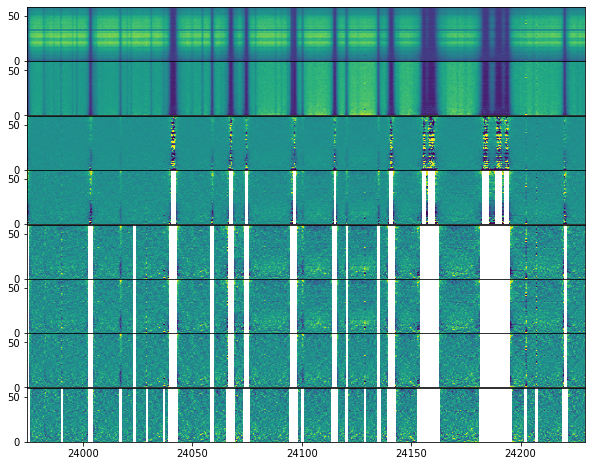

In [69]:
class Pipeline:
    def __init__(self, steps=[]):
        self.steps = steps
        self.args = ([None for _ in range(len(steps))])
        
    def add(self, step, args=None):
        self.steps.append(step)
        self.args.append(args)
        
    def reduce(self, dco, ax=None):
        print('Reducing order...')
        if not ax is None: dco.imshow(ax=ax[0])
        
        for i, fun in enumerate(self.steps):
            if not ax is None: dco.imshow(ax=ax[i])
            
            print('{:}. {:10}'.format(i+1, fun))
            if self.args[i] != None:
                dco = getattr(dco, fun)(**self.args[i])
            else:
                dco = getattr(dco, fun)()
                
            if not ax is None: dco.imshow(ax=ax[i+1])
            
        return dco
        
        
    
pipe = Pipeline()     
pipe.add('remove_continuum', {'mode':'polyfit'})
pipe.add('airmass_detrend')
pipe.add('mask_cols', {'sigma':2., 'mode':'flux', 'debug':True})
pipe.add('mask_cols', {'sigma':1., 'mode':'flux_err', 'cycles':2, 'debug':True})

pipe.add('sysrem', {'n':15})
pipe.add('high_pass_gaussian', {'window':15})
pipe.add('mask_cols', {'sigma':1.2, 'mode':'flux'})

n = len(pipe.steps) + 1

dco = dc.split_orders(debug=False).order(3) # split order in two sections (flux jump) and select a half-order to work with
fig, ax = plt.subplots(n,1, figsize=(10,1.*n))
plt.subplots_adjust(hspace=0.01)

dco = pipe.reduce(dco, ax=ax)

nans = np.isnan(dco.wlt)
frac_masked = nans[nans==True].size / nans.size
print('----{:.2f} % of pixels have been masked----'.format(100*frac_masked))
